# `Project using keras and backend as tensorflow`
-------------
- **Business Problem Statement:** Identify hand written digits by using data of MNIST
- [Read more about hand written digit database MNIST](http://yann.lecun.com/exdb/mnist/)

## Import Required Modules

In [30]:
# imports for array-handling and plotting
import os
import numpy as np
import matplotlib.pyplot as plt


# keras imports for the dataset
from keras.datasets import mnist

# keras imports building our neural network
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils

# ignore warnings
import warnings
warnings.simplefilter("ignore")

## Understanding and Preprocessing the Dataset

### Load train and test data

In [31]:
mnist.load_data?

Signature: mnist.load_data(path='mnist.npz')
Docstring:
Loads the MNIST dataset.

# Arguments
    path: path where to cache the dataset locally
        (relative to ~/.keras/datasets).

# Returns
    Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
File:      c:\users\ramreddymyla\anaconda3\envs\dl\lib\site-packages\keras\datasets\mnist.py
Type:      function


In [32]:
# Load the dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [33]:
len(X_train),len(X_test),len(y_train),len(y_test)

(60000, 10000, 60000, 10000)

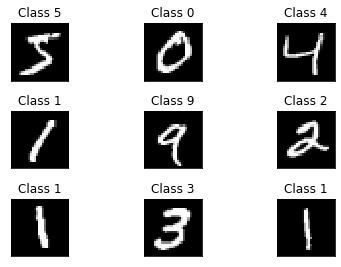

In [34]:
# Observe first 9 images of train data set
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(X_train[i], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[i]))
    plt.xticks([])
    plt.yticks([])    
plt.show()    

### Change the shape of input data from `3D to 2D`

In [35]:
X_train.shape

(60000, 28, 28)

In [36]:
X_train.ndim

3

- In order to train our neural network to classify images we first have to unroll the # height × width pixel format into one big vector - the input vector. So its length must be  28 * 28 = 784.


In [37]:
# let's print the shape before we reshape and normalize
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


In [38]:
n_samples_train=X_train.shape[0]
print(f"the number of traing samples are: {n_samples_train}")
n_features_train=X_train.shape[1] * X_train.shape[2]
print(f"the number of traing features are: {n_features_train}")

n_samples_test=X_test.shape[0]
print(f"the number of testing samples are: {n_samples_test}")
n_features_test=X_test.shape[1] * X_test.shape[2]
print(f"the number of testing features are: {n_features_test}")

the number of traing samples are: 60000
the number of traing features are: 784
the number of testing samples are: 10000
the number of testing features are: 784


In [39]:
# building the input vector from the 28x28 pixels
# converting 3D array(ex 60000 * 28 * 28) into 2d array( ex: 60000*784)
X_train = X_train.reshape(n_samples_train, n_features_train)
X_test = X_test.reshape(n_samples_test, n_features_test)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [40]:
X_train.shape

(60000, 784)

### Normalize the Input data

- Note that the pixel values range from 0 to 255: the background majority close to 0, and those close to 255 representing the digit.

- Normalizing the input data helps to speed up the training. Also, it reduces the chance of getting stuck in local optima, since we're using stochastic gradient descent to find the optimal weights for the network.
- Let's normalize the pixel values to lie between 0 and 1.

In [41]:
max(X_train[0])

255.0

In [42]:
min(X_train[0])

0.0

In [43]:
# observe one image fifferent pixels 
X_train[0][[144,155,156,159]]

array([  0.,  18., 126.,  26.], dtype=float32)

In [44]:
# normalizing the data to help with the training
X_train /= 255
X_test /= 255

In [45]:
X_train[0][[144,155,156,159]]

array([0.        , 0.07058824, 0.49411765, 0.10196079], dtype=float32)

In [46]:
# print the final input shape ready for training
print("Train matrix shape", X_train.shape)
print("Test matrix shape", X_test.shape)

Train matrix shape (60000, 784)
Test matrix shape (10000, 784)


### convert output y data into Categorical

In [47]:
y_train[0]

5

In [48]:
#Let us see the number of expected outcomes
print(np.unique(y_train, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949],
      dtype=int64))


- Let's encode our categories - digits from 0 to 9 - using one-hot encoding. The result is a vector with a length equal to the number of categories. The vector is all zeroes except in the position for the respective category. Thus a '5' will be represented by [0,0,0,0,0,1,0,0,0,0]

In [49]:
#one-hot encoding using keras' numpy-related utilities
n_classes = 10
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)


Shape before one-hot encoding:  (60000,)
Shape after one-hot encoding:  (60000, 10)


In [50]:
y_train[2]

4

In [51]:
Y_train[2]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)

In [52]:
y_train[3]

1

In [53]:
Y_train[3]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

## Building the Network

![image.png](https://github.com/rritec/datahexa/blob/dev/images/dl/arch.png?raw=true)


1.	Our pixel vector serves as the input. Then, two hidden 512-node layers, with enough model complexity for recognizing digits. For the multi-class classification we add another densely-connected (or fully-connected) layer for the 10 different output classes. For this network architecture we can use the Keras Sequential Model. We can stack layers using the .add() method.
2.	When adding the first layer in the Sequential Model we need to specify the input shape so Keras can create the appropriate matrices. For all remaining layers the shape is inferred automatically.
3.	In order to introduce nonlinearities into the network and elevate it beyond the capabilities of a simple perceptron we also add activation functions to the hidden layers. The differentiation for the training via backpropagation is happening behind the scenes without having to implement the details. 
4.	We also add **dropout** as a way to prevent overfitting. Here we randomly keep some network weights fixed when we would normally update them so that the network doesn't rely too much on very few nodes.
5.	The last layer consists of connections for our 10 classes and the **softmax activation** which is standard for multi-class targets.


In [54]:
#Dense?

In [55]:
n_cols=X_train.shape[1]
n_cols

784

In [56]:
Dropout?

Init signature: Dropout(rate, noise_shape=None, seed=None, **kwargs)
Docstring:     
Applies Dropout to the input.

Dropout consists in randomly setting
a fraction `rate` of input units to 0 at each update during training time,
which helps prevent overfitting.

# Arguments
    rate: float between 0 and 1. Fraction of the input units to drop.
    noise_shape: 1D integer tensor representing the shape of the
        binary dropout mask that will be multiplied with the input.
        For instance, if your inputs have shape
        `(batch_size, timesteps, features)` and
        you want the dropout mask to be the same for all timesteps,
        you can use `noise_shape=(batch_size, 1, features)`.
    seed: A Python integer to use as random seed.

# References
    - [Dropout: A Simple Way to Prevent Neural Networks from Overfitting]
      (http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)
File:           c:\users\ramreddymyla\anaconda3\envs\dl\lib\site-packages\keras\laye

In [57]:
# building a linear stack of layers with the sequential model
# define input and fitst hidden layers
model = Sequential()
model.add(Dense(512, input_shape=(n_cols,)))
model.add(Activation('relu'))                            
model.add(Dropout(0.2))

# define second hidden layer
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))

# define output layer
model.add(Dense(10))
model.add(Activation('softmax'))

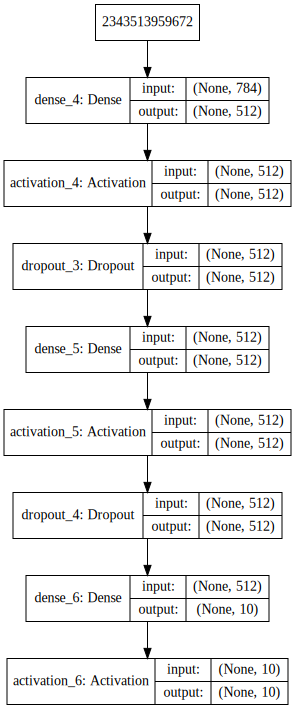

In [58]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model,show_shapes=True, show_layer_names=True,).create(prog='dot', format='svg'))

## Compiling and Training the Model

In [59]:
# compiling the sequential model
model.compile(loss='categorical_crossentropy', 
              metrics=['accuracy'], 
              optimizer='adam')
#We can start the training the model
# training the model and saving metrics in history
history = model.fit(X_train, Y_train,
          batch_size=128, epochs=8,
          #verbose=2,
          validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/8
60000/60000 [==============================] - 14s 241us/step - loss: 0.2501 - acc: 0.9255 - val_loss: 0.1070 - val_acc: 0.9668
Epoch 2/8
60000/60000 [==============================] - 14s 240us/step - loss: 0.1010 - acc: 0.9692 - val_loss: 0.0794 - val_acc: 0.9758
Epoch 3/8
60000/60000 [==============================] - 14s 225us/step - loss: 0.0704 - acc: 0.9772 - val_loss: 0.0720 - val_acc: 0.9790
Epoch 4/8
60000/60000 [==============================] - 14s 232us/step - loss: 0.0538 - acc: 0.9825 - val_loss: 0.0664 - val_acc: 0.9789
Epoch 5/8
60000/60000 [==============================] - 13s 217us/step - loss: 0.0473 - acc: 0.9848 - val_loss: 0.0798 - val_acc: 0.9766
Epoch 6/8
60000/60000 [==============================] - 14s 236us/step - loss: 0.0386 - acc: 0.9873 - val_loss: 0.0701 - val_acc: 0.9811
Epoch 7/8
60000/60000 [==============================] - 13s 213us/step - loss: 0.0351 - acc: 0.9882 - val_loss: 0.0635 - 

In [60]:
# saving the model
save_dir = "C:\\Users\\ramreddymyla\\Desktop\\rritec"
model_name = 'keras_mnist.h5'
model_path = os.path.join(save_dir, model_name)
model_path

'C:\\Users\\ramreddymyla\\Desktop\\rritec\\keras_mnist.h5'

In [61]:
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:\Users\ramreddymyla\Desktop\rritec\keras_mnist.h5 


### Observe metrics accuracy and loss

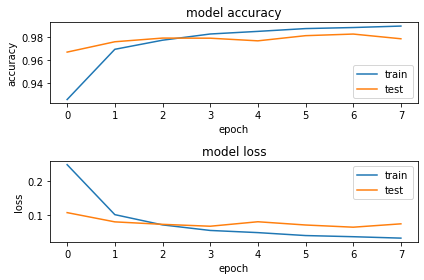

In [62]:
# plotting the metrics
#fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()
#fig

- Note: This learning curve looks quite **good!** We see that the loss on the training set is decreasing rapidly for the first two epochs. This shows the network is learning to classify the digits pretty fast. For the test set the loss does not decrease as fast but stays roughly within the same range as the training loss. This means our model generalizes well to unseen data.

## Evaluate the Model Performance

In [63]:
mnist_model = load_model(model_path)
loss_and_metrics = mnist_model.evaluate(X_test, Y_test, verbose=2)

print("Test Loss", loss_and_metrics[0])
print("Test Accuracy", loss_and_metrics[1])
#it is nothin but epoch 10values: val_loss: 0.0653 - val_acc: 0.9819

Test Loss 0.07355138200080401
Test Accuracy 0.9784


In [64]:
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [65]:
# load the model and create predictions on the test set
mnist_model = load_model(model_path)
predicted_classes = mnist_model.predict_classes(X_test)

# see which we predicted correctly and which not
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]
print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")


9784  classified correctly
216  classified incorrectly


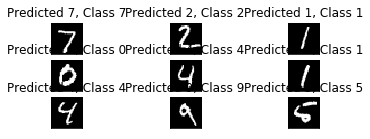

In [66]:
# plot 9 correct predictions
#fig = plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(6,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))
    plt.xticks([])
    plt.yticks([])
#fig

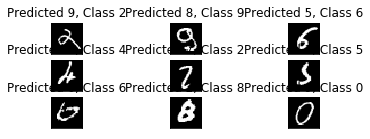

In [67]:
# plot 9 incorrect predictions
#fig = plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(6,3,i+10)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))
    plt.xticks([])
    plt.yticks([])

#fig